In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import warnings

from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.inspection import permutation_importance
from sklearn.metrics import RocCurveDisplay, roc_curve, auc, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold

from utils import generate_orf_id, load_features, Dataset
from modeling_utils import plot_roc_pr
from pathlib import Path

pd.set_option('display.max_columns', 100)

warnings.filterwarnings('ignore')

/home/ec2-user/miniconda3/lib/python3.10/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
data_dir = Path('data').absolute()

### Setup ML problem

In [3]:
truth_pos_df = pd.read_csv(data_dir.joinpath('truthset_positives.240227.tsv'), sep='\t')
truth_neg_df = pd.read_csv(data_dir.joinpath('truthset_negatives.240227.tsv'), sep='\t')

In [4]:
truth_pos_df['orf_id'] = truth_pos_df.apply(lambda x: generate_orf_id(x), axis=1)
truth_neg_df['orf_id'] = truth_neg_df.apply(lambda x: generate_orf_id(x), axis=1)
truth_df = pd.concat([truth_pos_df, truth_neg_df])

In [7]:
dataset_names = ['iPSC', 'MB1', 'Gaertner']
datasets = {}

X_dfs = []
y_arrays = []
orf_ids = []

for dataset_name in dataset_names:

    dataset_file_names = []
    with open(data_dir.joinpath(f'{dataset_name}.txt'), 'r') as infile:
        for line in infile.readlines():
            dataset_file_names.append(f"{line.rstrip('\n')}_orf_features.csv")

    truth_label = f'score.({dataset_name})'
    feature_df = load_features(data_dir, dataset_file_names)

    merged_df = truth_df[['orf_id', truth_label]].merge(feature_df, left_on='orf_id', right_index=True)
    merged_df.reset_index(inplace=True)

    y = merged_df[truth_label].copy()
    y[y > 0] = 1
    y = y.values

    numeric_feat_df = merged_df.drop(columns=['orf_id', truth_label, 'index'])
    X = numeric_feat_df

    X_dfs.append(X)
    y_arrays.append(y)
    orf_ids.append(merged_df['orf_id'])

    datasets[dataset_name] = Dataset(X, y, dataset_name, merged_df['orf_id'])

datasets['all'] = Dataset(pd.concat(X_dfs), np.concatenate(y_arrays), 'all',  pd.concat(orf_ids))

### Choose model

In [8]:
dataset_name = 'all'

ds = datasets[dataset_name]

#### Gradient boosting classifier (histogram based)

In [10]:
ds.X

,orf_start,orf_end,mean,sum,std,n_reads_orf_vs_transcript,pos_1_vs_0,pos_2_vs_0,frames_1_vs_0,frames_2_vs_0,five_utr_vs_cds_mean,five_utr_vs_cds_max,five_utr_vs_start_codon_mean,five_utr_vs_start_codon_max,cds_utr_vs_start_codon_mean,cds_utr_vs_start_codon_max,three_utr_vs_cds_mean,three_utr_vs_cds_max,three_utr_vs_stop_codon_mean,three_utr_vs_stop_codon_max,cds_utr_vs_stop_codon_mean,cds_utr_vs_stop_codon_max,dist_neg_100,dist_neg_150,dist_pos_100,dist_pos_150,price,ribotish,ribocode
0,119298778.0,119300535.0,0.084024,16.888864,0.174745,1.000000,9.000000,7.666667,0.118863,0.284981,0.471676,0.445487,0.197328,-0.397920,-0.306780,-0.843407,1.101565,0.781995,1.669626,0.739318,0.642049,0.152634,24.000000,36.000000,7.000000,10.000000,333.00000,0.000000,13.229984
1,164877331.0,164879008.0,0.072125,11.900549,0.114989,0.995578,0.000000,0.287698,0.156514,0.441996,0.366351,0.196041,0.406677,-0.231474,0.050369,-0.427516,3.000000,3.000000,3.000000,3.000000,-0.026329,-0.347829,27.000000,38.000000,10.666667,12.000000,666.00000,0.000000,10.281421
2,211391639.0,211426222.0,0.002172,0.618964,0.011806,0.271739,10.000000,10.000000,0.600000,0.066667,0.111436,0.000000,0.433656,-0.397940,0.410174,-0.397940,-0.801632,-0.477121,0.176091,-0.477121,1.255273,0.000000,1.000000,1.000000,1.000000,1.000000,0.00000,0.000000,2.330887
3,103951522.0,103956738.0,0.019943,4.307726,0.046973,0.867896,10.000000,10.000000,0.148938,0.397701,0.956947,0.452327,1.059631,0.298750,0.132361,-0.153577,0.659143,0.440740,-1.877341,-2.100343,-2.053234,-2.200687,20.666667,20.666667,8.333333,87.000000,337.95061,0.000000,7.009958
4,117839801.0,117842776.0,0.021059,6.064981,0.054491,1.000000,10.000000,10.000000,0.150283,0.249963,2.377542,2.232990,2.515866,2.232990,0.651793,0.349797,0.777362,0.463055,1.332207,0.281699,0.646401,-0.100343,60.000000,60.000000,287.000000,287.000000,670.91850,13.844369,9.231052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4320,29574701.0,29575099.0,0.006398,1.497130,0.023246,0.998609,10.000000,10.000000,0.063286,0.122910,-0.224263,-0.085210,-0.263075,-0.555450,0.090217,-0.308329,2.936162,2.920069,-2.600000,-2.600000,-2.786328,-2.847712,13.400000,22.566667,13.333333,41.466667,0.00000,0.000000,6.864412
4321,23346647.0,23347562.0,0.006785,3.053272,0.022312,0.982952,10.000000,10.000000,0.067736,0.127614,0.151145,0.136862,-1.129141,-1.288964,-1.264273,-1.417660,2.852135,2.810034,-2.200000,-2.200000,-2.489969,-2.615904,2.966667,5.600000,1.400000,2.133333,0.00000,0.000000,12.501521
4322,18444751.0,18444826.0,0.006380,0.478524,0.021891,1.000000,10.000000,10.000000,0.000000,0.000000,1.410223,1.274636,1.549674,1.141990,0.159040,-0.132647,3.000000,3.000000,-3.000000,-3.000000,-3.000000,-3.000000,39.333333,40.333333,35.000000,35.000000,1.72455,0.000000,1.341375
4323,50876500.0,50876608.0,0.016384,1.769489,0.043546,1.000000,0.000000,0.083333,0.057347,0.267889,0.711144,0.426472,0.566768,-0.173963,-0.154746,-0.600435,2.057904,1.778088,-1.796777,-1.985665,-2.254807,-2.422787,6.047619,13.047619,6.666667,20.619048,0.00000,0.000000,4.688288


In [14]:
len(ds.y)

10577

In [15]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],  # Controls the contribution of each tree to the final outcome and helps to prevent overfitting by shrinking the tree predictions.
    'max_iter': [100, 200, 300, 400, 500],  # Maximum number of iterations of the boosting process, equivalent to n_estimators in other GBM frameworks.
    'max_depth': [None, 5, 10, 20],  # Maximum depth of each tree. None means no limit.
    'min_samples_leaf': [20, 40, 60, 80],  # Minimum number of samples per leaf. Can be used to smooth the model, especially in regression.
    'l2_regularization': [0.0, 0.01, 0.1, 1.0],  # L2 regularization term on weights, increasing this value will make model more conservative.
    'max_bins': [200, 255],  # Maximum number of bins used for splitting features. Higher values increase model's ability to capture detail but also computation time.
    'categorical_features': [None, 'auto'],  # Whether to treat integer features as categorical. 'auto' lets the model decide.
}

hclf = RandomizedSearchCV(HistGradientBoostingClassifier(), param_grid, random_state=0, n_jobs=32, n_iter=300)
search = hclf.fit(ds.X, ds.y)
search.best_params_
classifier = HistGradientBoostingClassifier(class_weight='balanced', **search.best_params_)

#### Gradient boosting classifier (standard)

In [22]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 0.2, 0.5],
    'subsample': [0.8, 0.9, 1.0],
    'loss': ['deviance', 'exponential'],
}

gclf = RandomizedSearchCV(GradientBoostingClassifier(), param_grid, random_state=0, n_jobs=32, n_iter=300)
search = gclf.fit(ds.X, ds.y)
search.best_params_
classifier = GradientBoostingClassifier(**search.best_params_)

#### Random forest classifier

In [94]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree. None means no limit
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
    'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree
    'class_weight': [None, 'balanced', 'balanced_subsample'],  # Weights associated with classes. 'balanced_subsample' will adjust weights based on the bootstrap sample for every tree grown
}

rclf = RandomizedSearchCV(RandomForestClassifier(), param_grid, random_state=0, n_jobs=32)
search = rclf.fit(ds.X, ds.y)
search.best_params_
classifier = RandomForestClassifier(**search.best_params_)

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'class_weight': 'balanced',
 'bootstrap': True}

In [16]:
sum(ds.y)

724

In [17]:
ds.name

'all'

In [18]:
len(ds.X)

10577

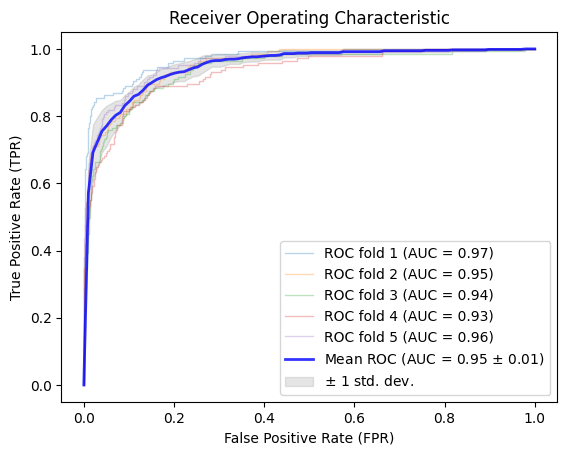

In [37]:
cv = StratifiedKFold(n_splits=5)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()

fpr_cutoff=0.05
closest_fpr_diff = float('inf')
best_model = None
feature_importances = []

for i, (train, test) in enumerate(cv.split(ds.X, ds.y)):
    
    cloned_classifier = clone(classifier)

    cloned_classifier.fit(ds.X.iloc[train], ds.y[train])
    viz = roc_curve(ds.y[test], cloned_classifier.predict_proba(ds.X.iloc[test])[:, 1])
    fpr, tpr, thresholds = viz
    #feature_importances.append(cloned_classifier.feature_importances_)
    
    fpr_diff = np.abs(fpr - fpr_cutoff)
    min_fpr_diff_index = np.argmin(fpr_diff)
    if fpr_diff[min_fpr_diff_index] < closest_fpr_diff:
        closest_fpr_diff = fpr_diff[min_fpr_diff_index]
        best_model = cloned_classifier
        ds.model = cloned_classifier

    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')
    

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')
ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR)')
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver Operating Characteristic")
ax.legend(loc="lower right")
plt.show()

In [38]:
cloned_classifier.fit(ds.X.iloc[train], ds.y[train])
viz = roc_curve(ds.y[test], cloned_classifier.predict_proba(ds.X.iloc[test])[:, 1])
fpr, tpr, thresholds = viz

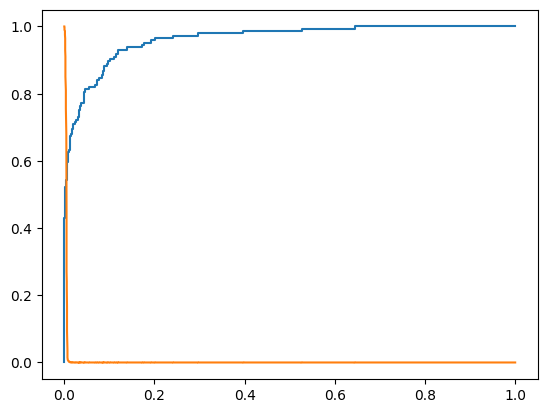

In [48]:
fig, ax = plt.subplots()

ax.plot(fpr, tpr)
ax.plot(fpr, thresholds)

In [43]:
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

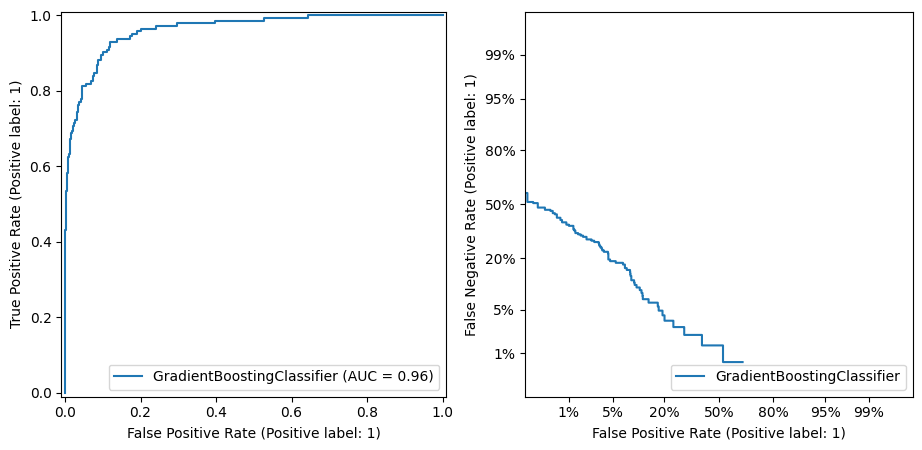

In [44]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))
RocCurveDisplay.from_estimator(cloned_classifier, ds.X.iloc[test], ds.y[test], ax=ax_roc)
DetCurveDisplay.from_estimator(cloned_classifier, ds.X.iloc[test], ds.y[test], ax=ax_det)

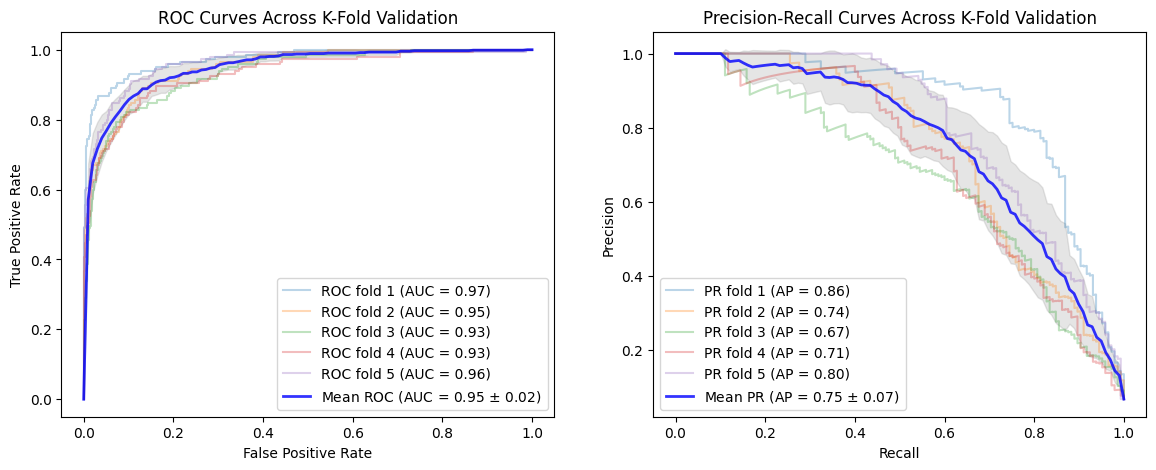

In [34]:
best_model, feature_importances, roc_pr_fig = plot_roc_pr2(ds.X, ds.y, classifier, n_splits=5, fpr_cutoff=.2)

In [49]:
ds.model = classifier.fit(ds.X, ds.y)

In [11]:
roc_pr_fig.savefig(f'plots/roc_pr_{dataset_name}.png', dpi=200, bbox_inches='tight')

In [12]:
def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=100, random_state=42, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

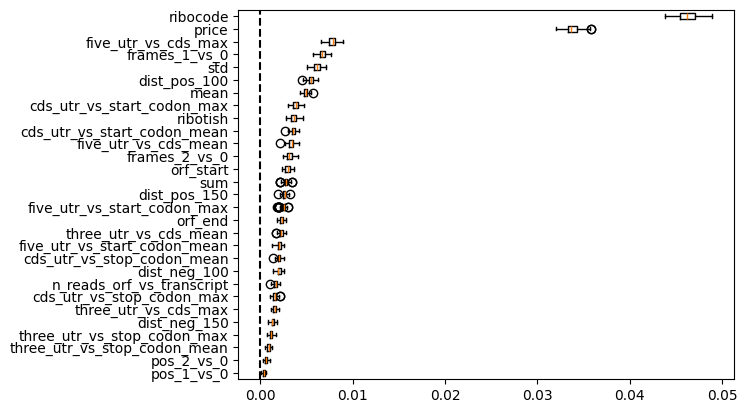

In [13]:
fig, ax = plt.subplots()
plot_permutation_importance(ds.model, ds.X, ds.y, ax)
fig.savefig(f'plots/feature_importance_{dataset_name}.png', dpi=200, bbox_inches='tight')

In [27]:
fi_df = pd.DataFrame(feature_importances, columns=numeric_feat_df.columns)
medians = fi_df.median()
sorted_columns = medians.sort_values(ascending=False).index
sorted_df = fi_df[sorted_columns]
plot_df = fi_df.melt(var_name='Category', value_name='Value')

<Axes: xlabel='Value', ylabel='Category'>

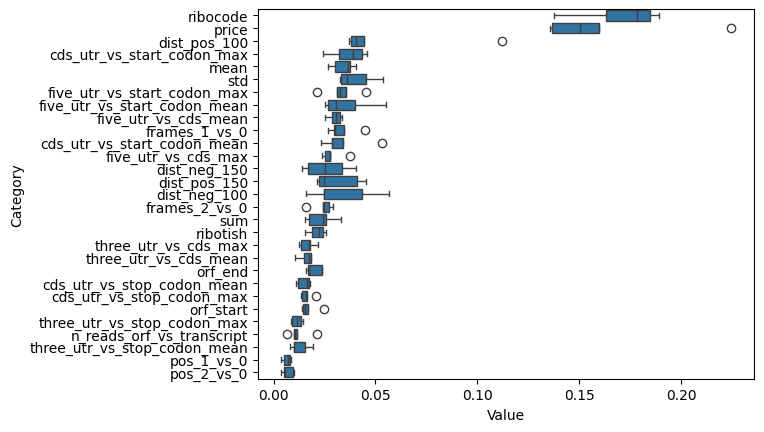

In [28]:
bplot = sns.boxplot(plot_df, y='Category', x='Value', order=sorted_df.columns)
bplot

In [29]:
bplot.figure.savefig(f'plots/feature_importance_impurity_{dataset_name}.png', dpi=200, bbox_inches='tight')

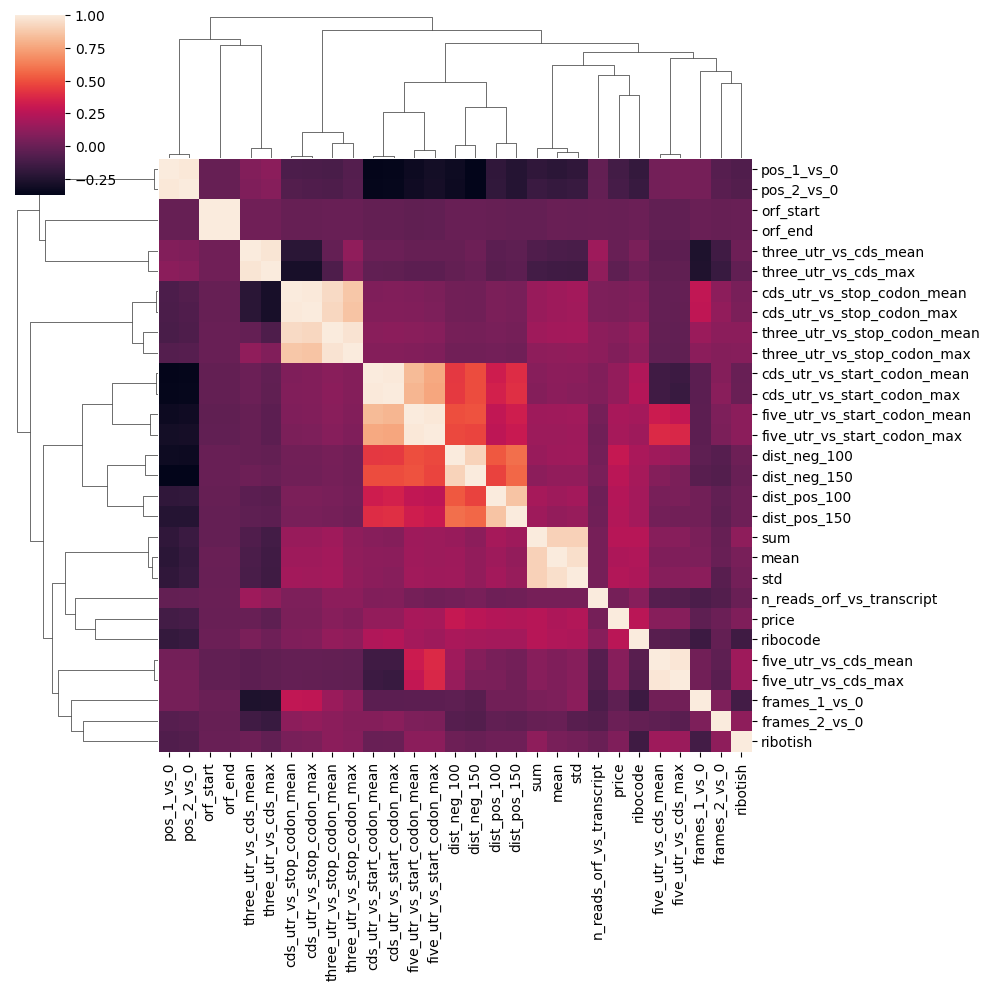

In [30]:
sns.clustermap(ds.X.corr())

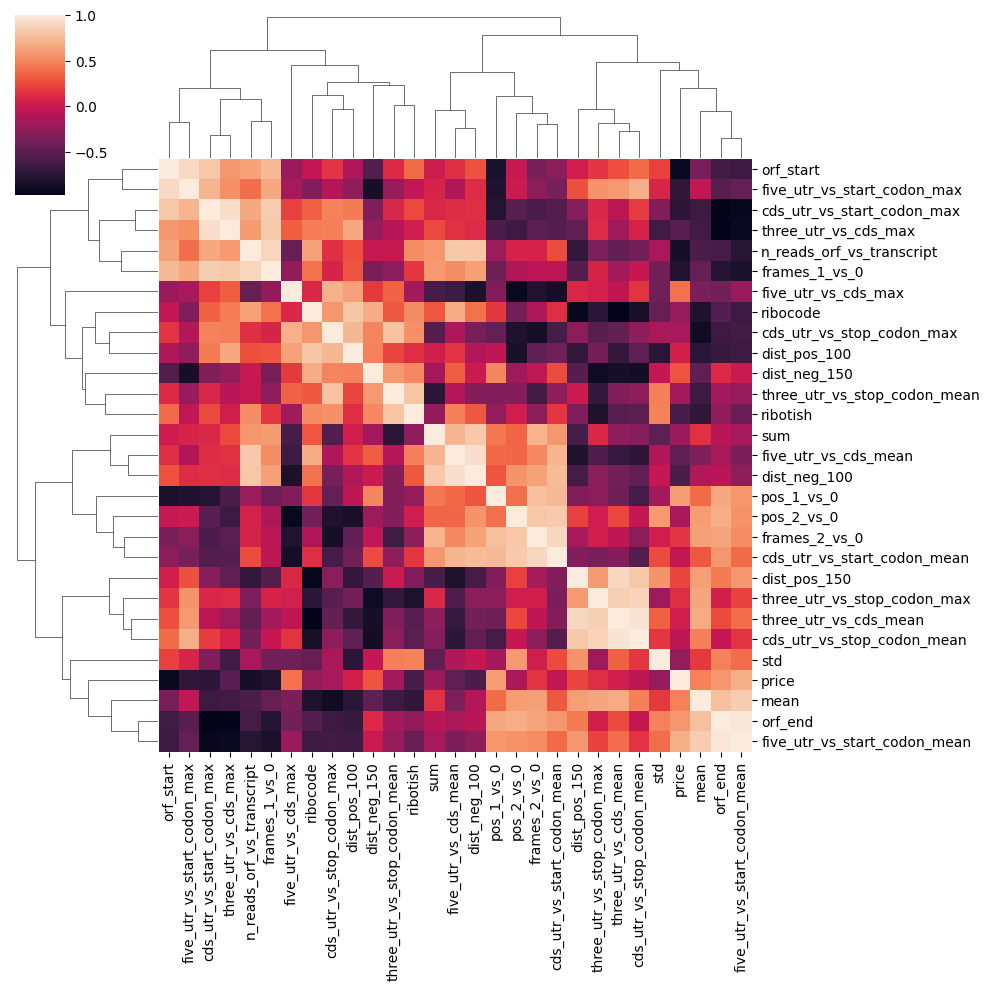

In [46]:
sns.clustermap(fi_df.corr())

In [105]:
cloned_classifier.predict(X)

array([1, 1, 1, ..., 0, 0, 0])

In [69]:
ds.name

'iPSC'

In [90]:
print(classification_report(datasets['Gaertner'].y, best_model.predict(datasets['Gaertner'].X)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4042
           1       0.83      0.24      0.37       283

    accuracy                           0.95      4325
   macro avg       0.89      0.62      0.67      4325
weighted avg       0.94      0.95      0.93      4325



In [92]:
print(classification_report(datasets['iPSC'].y, best_model.predict(datasets['iPSC'].X)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3333
           1       0.90      0.40      0.55       238

    accuracy                           0.96      3571
   macro avg       0.93      0.70      0.77      3571
weighted avg       0.96      0.96      0.95      3571



In [101]:
print(classification_report(datasets['Gaertner'].y, best_model.predict(datasets['Gaertner'].X)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4042
           1       0.67      0.58      0.62       283

    accuracy                           0.95      4325
   macro avg       0.82      0.78      0.80      4325
weighted avg       0.95      0.95      0.95      4325



In [103]:
print(classification_report(datasets['MB1'].y, best_model.predict(datasets['MB1'].X)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2478
           1       0.78      0.37      0.50       203

    accuracy                           0.94      2681
   macro avg       0.87      0.68      0.74      2681
weighted avg       0.94      0.94      0.94      2681



In [32]:
import pickle

In [36]:
with open(f'data/top_model_{dataset_name}_gb.pkl', 'wb') as file:
    pickle.dump(ds, file)

In [ ]:
with open(filename, 'wb') as file:
    pickle.dump(data, file)